# House Prices - Advanced Regression Techniques

You have some experience with R or Python and machine learning basics. This is a perfect competition for data science students who have completed an online course in machine learning and are looking to expand their skill set before trying a featured competition. 

## Competition Description

![](https://kaggle2.blob.core.windows.net/competitions/kaggle/5407/media/housesbanner.png)

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

## Practice Skills
* Creative feature engineering 
* Advanced regression techniques like random forest and gradient boosting



In [1]:
import urllib
import zipfile
import os

if not os.path.exists('./data'):
    os.mkdir('./data')

zipfile.ZipFile('all.zip').extractall("./data")

In [2]:
import pandas as pd
import numpy as np

train = pd.read_csv('./data/train.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
categorical = [
    'MSSubClass',
    'MSZoning',
    'Street',
    'Alley',
    'LotShape',
    'LandContour',
    'Utilities',
    'LotConfig',
    'LandSlope',
    'Neighborhood',
    'Condition1',
    'Condition2',
    'BldgType',
    'HouseStyle',
    'RoofStyle',
    'RoofMatl',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'ExterQual',
    'ExterCond',
    'Foundation',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'Heating',
    'HeatingQC',
    'CentralAir',
    'Electrical',
    'KitchenQual',
    'Functional',
    'FireplaceQu',
    'GarageType',
    'GarageFinish',
    'GarageQual',
    'GarageCond',
    'PavedDrive',
    'PoolQC',
    'Fence',
    'MiscFeature',
    'SaleType',
    'SaleCondition'
]

def conv_categorical(df, missing_cat='None'):
    df[categorical] = df[categorical].astype("category")
    return df
    
train = conv_categorical(train)

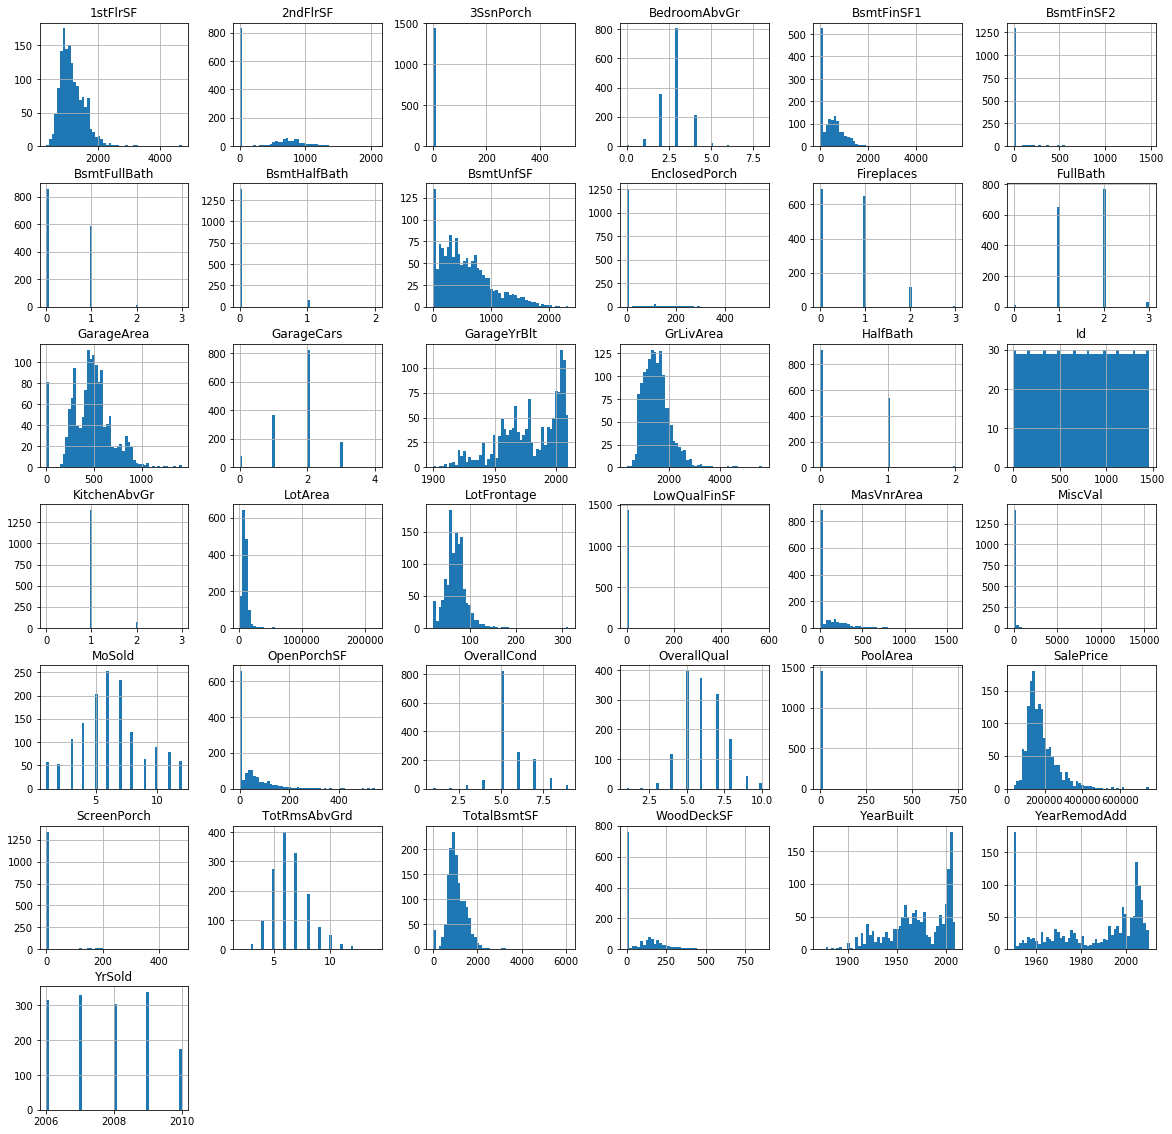

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
train.hist(bins=50, figsize=(20,20))
plt.show()

In [5]:
corr_matrix = train.corr()
top_corr = corr_matrix["SalePrice"].sort_values(ascending=False)
top_corr

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

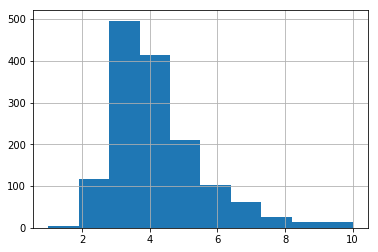

In [6]:
train['SaleBin'] = np.ceil(train['SalePrice']/50000)
train['SaleBin'].where(train['SaleBin'] < 10, 10, inplace=True)
train['SaleBin'].hist()

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in split.split(train, train['SaleBin']):
    train_set = train.loc[train_idx]
    test_set = train.loc[test_idx]
    
print(train_set.shape)
print(test_set.shape)

(1168, 82)
(292, 82)


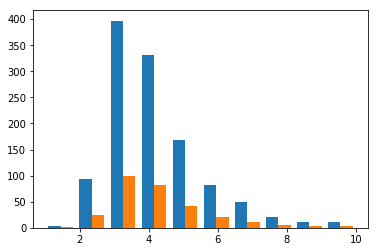

In [8]:
# check distribution of train and test set

fig = plt.figure()
ax = fig.add_subplot(111)
_ = ax.hist([train_set['SaleBin'].values, test_set['SaleBin'].values])

In [9]:
# drop columns with some undefined data
features = train.columns[train.notna().all()].values
features = features[~np.in1d(features, ["Id", "SalePrice", "SaleBin"])]
cat = np.intersect1d(features, np.array(categorical))
non_cat = np.setdiff1d(features, np.array(categorical))
features

array(['MSSubClass', 'MSZoning', 'LotArea', 'Street', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageCars',
       'GarageArea', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SaleType', 'SaleCondition'], dtype=object)

In [10]:
# standardize features
train[categorical]

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
    ("missing", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

cat_pipeline = Pipeline([
    ("const", SimpleImputer(strategy="constant", fill_value="None")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))
])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, non_cat),
        ("cat", cat_pipeline, cat),
    ])

full_pipeline.fit(train[features])

all_trans = full_pipeline.transform(train[features])
train_trans = full_pipeline.transform(train_set[features])
test_trans = full_pipeline.transform(test_set[features])

assert train_trans.shape[1] == test_trans.shape[1]

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

train_labels = train['SalePrice']

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=100, cv=5, scoring='neg_mean_squared_log_error', random_state=42, verbose=5)
rnd_search.fit(all_trans, train_labels)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] max_features=7, n_estimators=180 ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_features=7, n_estimators=180, score=-0.019440747065864884, total=   1.1s
[CV] max_features=7, n_estimators=180 ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV]  max_features=7, n_estimators=180, score=-0.0295271744833526, total=   1.1s
[CV] max_features=7, n_estimators=180 ................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s


[CV]  max_features=7, n_estimators=180, score=-0.02578534027788487, total=   1.1s
[CV] max_features=7, n_estimators=180 ................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.6s remaining:    0.0s


[CV]  max_features=7, n_estimators=180, score=-0.022426826266531807, total=   1.1s
[CV] max_features=7, n_estimators=180 ................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.8s remaining:    0.0s


[CV]  max_features=7, n_estimators=180, score=-0.02395318179349262, total=   1.2s
[CV] max_features=5, n_estimators=15 .................................
[CV]  max_features=5, n_estimators=15, score=-0.021992824291359868, total=   0.1s
[CV] max_features=5, n_estimators=15 .................................
[CV]  max_features=5, n_estimators=15, score=-0.031813292168106376, total=   0.1s
[CV] max_features=5, n_estimators=15 .................................
[CV]  max_features=5, n_estimators=15, score=-0.029465779561505822, total=   0.1s
[CV] max_features=5, n_estimators=15 .................................
[CV]  max_features=5, n_estimators=15, score=-0.02697414501074683, total=   0.1s
[CV] max_features=5, n_estimators=15 .................................
[CV]  max_features=5, n_estimators=15, score=-0.031245337187043105, total=   0.1s
[CV] max_features=3, n_estimators=72 .................................
[CV]  max_features=3, n_estimators=72, score=-0.02275439353095458, total=   0.4s
[C

[CV]  max_features=6, n_estimators=130, score=-0.023011787829690718, total=   0.8s
[CV] max_features=6, n_estimators=130 ................................
[CV]  max_features=6, n_estimators=130, score=-0.025701723619199777, total=   0.8s
[CV] max_features=4, n_estimators=21 .................................
[CV]  max_features=4, n_estimators=21, score=-0.02252108914601185, total=   0.1s
[CV] max_features=4, n_estimators=21 .................................
[CV]  max_features=4, n_estimators=21, score=-0.03520673745340153, total=   0.1s
[CV] max_features=4, n_estimators=21 .................................
[CV]  max_features=4, n_estimators=21, score=-0.03197654331513512, total=   0.1s
[CV] max_features=4, n_estimators=21 .................................
[CV]  max_features=4, n_estimators=21, score=-0.027884755913949198, total=   0.1s
[CV] max_features=4, n_estimators=21 .................................
[CV]  max_features=4, n_estimators=21, score=-0.027861910747602102, total=   0.1s
[

[CV]  max_features=4, n_estimators=64, score=-0.029692242390958527, total=   0.4s
[CV] max_features=4, n_estimators=64 .................................
[CV]  max_features=4, n_estimators=64, score=-0.025822472249802195, total=   0.3s
[CV] max_features=4, n_estimators=64 .................................
[CV]  max_features=4, n_estimators=64, score=-0.027182564310656954, total=   0.3s
[CV] max_features=1, n_estimators=131 ................................
[CV]  max_features=1, n_estimators=131, score=-0.02727806934285517, total=   0.6s
[CV] max_features=1, n_estimators=131 ................................
[CV]  max_features=1, n_estimators=131, score=-0.037470384013906816, total=   0.6s
[CV] max_features=1, n_estimators=131 ................................
[CV]  max_features=1, n_estimators=131, score=-0.03444390720494414, total=   0.6s
[CV] max_features=1, n_estimators=131 ................................
[CV]  max_features=1, n_estimators=131, score=-0.029441255813574114, total=   0.6

[CV]  max_features=4, n_estimators=199, score=-0.03319790314441422, total=   1.1s
[CV] max_features=4, n_estimators=199 ................................
[CV]  max_features=4, n_estimators=199, score=-0.028756638400212364, total=   1.1s
[CV] max_features=4, n_estimators=199 ................................
[CV]  max_features=4, n_estimators=199, score=-0.024181257284027823, total=   1.1s
[CV] max_features=4, n_estimators=199 ................................
[CV]  max_features=4, n_estimators=199, score=-0.026743735187084314, total=   1.1s
[CV] max_features=4, n_estimators=8 ..................................
[CV]  max_features=4, n_estimators=8, score=-0.028203633937120425, total=   0.0s
[CV] max_features=4, n_estimators=8 ..................................
[CV]  max_features=4, n_estimators=8, score=-0.03863297567778887, total=   0.0s
[CV] max_features=4, n_estimators=8 ..................................
[CV]  max_features=4, n_estimators=8, score=-0.035226489049422924, total=   0.0s
[

[CV]  max_features=2, n_estimators=190, score=-0.023709852899894638, total=   0.9s
[CV] max_features=2, n_estimators=190 ................................
[CV]  max_features=2, n_estimators=190, score=-0.03575750267802672, total=   0.9s
[CV] max_features=2, n_estimators=190 ................................
[CV]  max_features=2, n_estimators=190, score=-0.032146276649665385, total=   0.9s
[CV] max_features=2, n_estimators=190 ................................
[CV]  max_features=2, n_estimators=190, score=-0.02794577161069857, total=   0.9s
[CV] max_features=2, n_estimators=190 ................................
[CV]  max_features=2, n_estimators=190, score=-0.02985337736084296, total=   0.9s
[CV] max_features=4, n_estimators=14 .................................
[CV]  max_features=4, n_estimators=14, score=-0.023766346560266844, total=   0.1s
[CV] max_features=4, n_estimators=14 .................................
[CV]  max_features=4, n_estimators=14, score=-0.03505820677244455, total=   0.1s

[CV]  max_features=1, n_estimators=71, score=-0.032535936434220446, total=   0.3s
[CV] max_features=1, n_estimators=88 .................................
[CV]  max_features=1, n_estimators=88, score=-0.027445467885425297, total=   0.4s
[CV] max_features=1, n_estimators=88 .................................
[CV]  max_features=1, n_estimators=88, score=-0.03807358486433658, total=   0.4s
[CV] max_features=1, n_estimators=88 .................................
[CV]  max_features=1, n_estimators=88, score=-0.034508729799229025, total=   0.4s
[CV] max_features=1, n_estimators=88 .................................
[CV]  max_features=1, n_estimators=88, score=-0.02925669886588723, total=   0.4s
[CV] max_features=1, n_estimators=88 .................................
[CV]  max_features=1, n_estimators=88, score=-0.032516861741991386, total=   0.4s
[CV] max_features=1, n_estimators=136 ................................
[CV]  max_features=1, n_estimators=136, score=-0.02710390029934293, total=   0.6s
[C

[CV]  max_features=1, n_estimators=48, score=-0.029993743950712044, total=   0.2s
[CV] max_features=1, n_estimators=48 .................................
[CV]  max_features=1, n_estimators=48, score=-0.03265774006345957, total=   0.2s
[CV] max_features=7, n_estimators=151 ................................
[CV]  max_features=7, n_estimators=151, score=-0.019447867011681035, total=   1.0s
[CV] max_features=7, n_estimators=151 ................................
[CV]  max_features=7, n_estimators=151, score=-0.029340902411727005, total=   1.0s
[CV] max_features=7, n_estimators=151 ................................
[CV]  max_features=7, n_estimators=151, score=-0.026102824471833257, total=   1.0s
[CV] max_features=7, n_estimators=151 ................................
[CV]  max_features=7, n_estimators=151, score=-0.022228407060617943, total=   1.0s
[CV] max_features=7, n_estimators=151 ................................
[CV]  max_features=7, n_estimators=151, score=-0.02433742108398303, total=   1.

[CV]  max_features=2, n_estimators=42, score=-0.032216780809870726, total=   0.2s
[CV] max_features=2, n_estimators=42 .................................
[CV]  max_features=2, n_estimators=42, score=-0.029607409423708347, total=   0.2s
[CV] max_features=2, n_estimators=42 .................................
[CV]  max_features=2, n_estimators=42, score=-0.032256305461445964, total=   0.2s
[CV] max_features=4, n_estimators=179 ................................
[CV]  max_features=4, n_estimators=179, score=-0.020782908998316894, total=   1.0s
[CV] max_features=4, n_estimators=179 ................................
[CV]  max_features=4, n_estimators=179, score=-0.033453320178563783, total=   1.0s
[CV] max_features=4, n_estimators=179 ................................
[CV]  max_features=4, n_estimators=179, score=-0.02879324545020517, total=   1.0s
[CV] max_features=4, n_estimators=179 ................................
[CV]  max_features=4, n_estimators=179, score=-0.024371628538545992, total=   1.

[CV]  max_features=4, n_estimators=66, score=-0.032933480363372486, total=   0.4s
[CV] max_features=4, n_estimators=66 .................................
[CV]  max_features=4, n_estimators=66, score=-0.029735514895394534, total=   0.4s
[CV] max_features=4, n_estimators=66 .................................
[CV]  max_features=4, n_estimators=66, score=-0.025776843760369907, total=   0.4s
[CV] max_features=4, n_estimators=66 .................................
[CV]  max_features=4, n_estimators=66, score=-0.027161990251411302, total=   0.4s
[CV] max_features=2, n_estimators=45 .................................
[CV]  max_features=2, n_estimators=45, score=-0.025688137571908416, total=   0.2s
[CV] max_features=2, n_estimators=45 .................................
[CV]  max_features=2, n_estimators=45, score=-0.03675634611954881, total=   0.2s
[CV] max_features=2, n_estimators=45 .................................
[CV]  max_features=2, n_estimators=45, score=-0.03221138832159802, total=   0.2s
[C

[CV]  max_features=1, n_estimators=27, score=-0.03914103539005516, total=   0.1s
[CV] max_features=1, n_estimators=27 .................................
[CV]  max_features=1, n_estimators=27, score=-0.039028518486290346, total=   0.1s
[CV] max_features=1, n_estimators=27 .................................
[CV]  max_features=1, n_estimators=27, score=-0.030570683311609413, total=   0.1s
[CV] max_features=1, n_estimators=27 .................................
[CV]  max_features=1, n_estimators=27, score=-0.03452518249447608, total=   0.1s
[CV] max_features=6, n_estimators=121 ................................
[CV]  max_features=6, n_estimators=121, score=-0.01884901061060936, total=   0.7s
[CV] max_features=6, n_estimators=121 ................................
[CV]  max_features=6, n_estimators=121, score=-0.03128666295356532, total=   0.7s
[CV] max_features=6, n_estimators=121 ................................
[CV]  max_features=6, n_estimators=121, score=-0.0265749649118867, total=   0.7s
[CV

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  4.5min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=None,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbd1698a630>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbd169a8eb8>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_log_error',
          verbose=5)

In [12]:
predictor = rnd_search.best_estimator_
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.15564913741304626 {'max_features': 7, 'n_estimators': 180}
0.16822091321756757 {'max_features': 5, 'n_estimators': 15}
0.17045132351587602 {'max_features': 3, 'n_estimators': 72}
0.16717308089597188 {'max_features': 5, 'n_estimators': 21}
0.15583144236300525 {'max_features': 7, 'n_estimators': 122}
0.1701035424186576 {'max_features': 3, 'n_estimators': 75}
0.16941400601953296 {'max_features': 3, 'n_estimators': 88}
0.16088763358406186 {'max_features': 5, 'n_estimators': 100}
0.1676865279204681 {'max_features': 3, 'n_estimators': 150}
0.22340534554068622 {'max_features': 5, 'n_estimators': 2}
0.16377646323305559 {'max_features': 4, 'n_estimators': 158}
0.1581719259011065 {'max_features': 6, 'n_estimators': 130}
0.170558515809736 {'max_features': 4, 'n_estimators': 21}
0.18280818158380915 {'max_features': 1, 'n_estimators': 58}
0.1589187869343143 {'max_features': 6, 'n_estimators': 89}
0.1826926745226771 {'max_features': 1, 'n_estimators': 59}
0.15548254875653905 {'max_features': 7, 'n

In [13]:
test = pd.read_csv('./data/test.csv')

test = conv_categorical(test)

print(test.shape)
test_trans = full_pipeline.transform(test[features])
print(test_trans.shape)
test_labels = predictor.predict(test_trans)
print(test_labels.shape)

(1459, 80)
(1459, 229)
(1459,)


In [16]:
results = pd.DataFrame({'Id': test['Id'].values, 'SalePrice': test_labels})
results.to_csv('./results.csv', header=True, index=False)